In [1]:
using Plots
theme(:gruvbox_light)

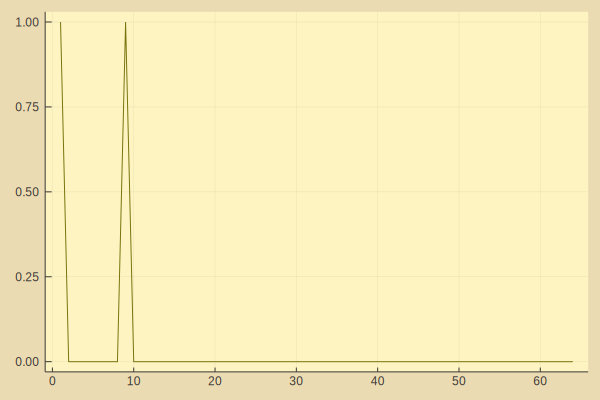

In [25]:
# Simple delay, feedforward design
# A single repeats after some time, with no feedback

N = 64
impulse = [1 ; zeros(N - 1)];
output = zeros(N);

buffer = zeros(32);
delay_time = 8;
write_index = 1;

for i in 1:N
    read_index = write_index - delay_time;
    if read_index < 1
        read_index += length(buffer)
    end
    output_sample = buffer[read_index];
    buffer[write_index] = impulse[i];
    write_index += 1
    if write_index > length(buffer)
        write_index -= length(buffer)
    end
    
    output[i] = impulse[i] + output_sample;
end

plot(output, legend=false)

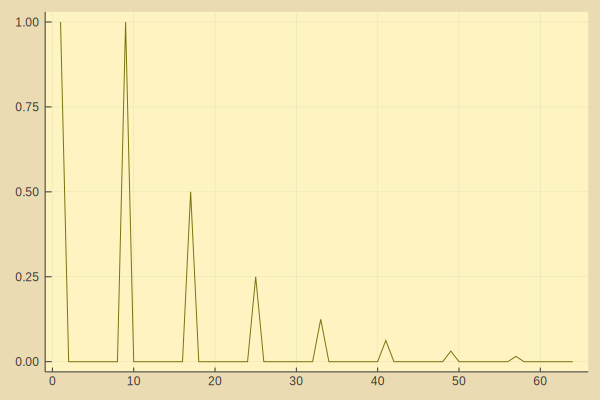

In [28]:
# Delay with Feedback

N = 64
impulse = [1 ; zeros(N - 1)];
output = zeros(N);

buffer = zeros(32);
delay_time = 8;
write_index = 1;

feedback_amount = 0.5;

for i in 1:N
    read_index = write_index - delay_time;
    if read_index < 1
        read_index += length(buffer)
    end
    output_sample = buffer[read_index];
    buffer[write_index] = impulse[i] + output_sample * feedback_amount;
    write_index += 1
    if write_index > length(buffer)
        write_index -= length(buffer)
    end
    
    output[i] = impulse[i] + output_sample;
end

plot(output, legend=false)

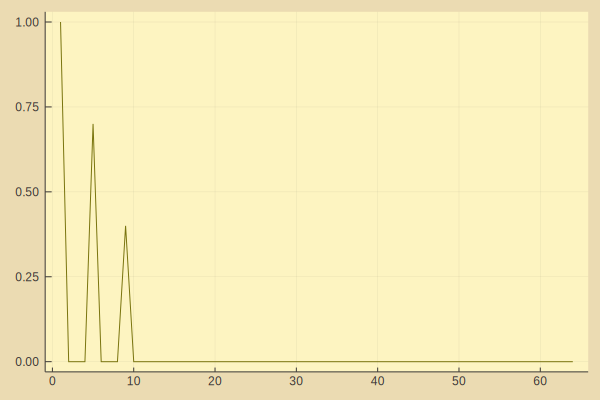

In [34]:
# Multitap Delay

N = 64
impulse = [1 ; zeros(N - 1)];
output = zeros(N);

buffer = zeros(32);
taps = [(4, 0.7), (8, 0.4)];
write_index = 1;

feedback_amount = 0.5;

for i in 1:N
    output_sample = 0.0;
    
    # Process each delay tap
    for (delay_time, amount) in taps
        read_index = write_index - delay_time;
        if read_index < 1
            read_index += length(buffer)
        end
        output_sample += buffer[read_index] * amount;
    end
    
    # Write result into buffer
    buffer[write_index] = impulse[i];
    
    # Increment write index
    write_index += 1
    if write_index > length(buffer)
        write_index -= length(buffer)
    end 
    
    # Write input + delay result to output
    output[i] = impulse[i] + output_sample;
end

plot(output, legend=false)

The challenge with multitap delay is that using feedback immediately adds copies of each tap back into the
buffer, while the desired effect (emulating the ValhallaDSP Uberdelay plugin) is to apply feedback to the
entire buffer at some interval. One approach may be to use a capture buffer, that records output, and whose
internal value is added into the original buffer, while delay tap values are not. Therefore, delay taps will
be applied to the input and the capture buffer, and the buffer will include the capture buffer value from
`signal_length` ago, times `feedback_amount`. 

Each run through the capture buffer, we add the current capture buffer value times feedback amount, plus the
current output (buffer value plus sum of taps). Delay output is `input_buffer[i] + capture_buffer[i]`.

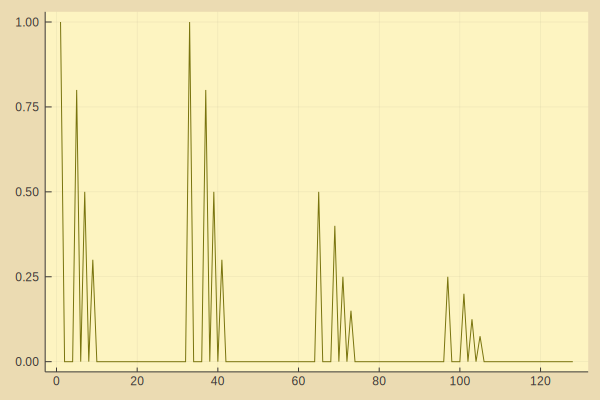

In [55]:
N = 128;
impulse = [1; zeros(N - 1)];
taps = [(4, 0.8), (6, 0.5), (8, 0.3)];

function multitap_delay(input, taps, pattern_length, feedback_amount)
    capture_buffer = zeros(N);
    input_buffer = zeros(N);
    output = zeros(N);
    write_index = 1;
    c_write_index = 1;
    
    for i in 1:N
         delay_output_sample = 0.0;

        # Process each delay tap by reading from the input buffer
        for (delay_time, amount) in taps
            read_index = write_index - delay_time;
            if read_index < 1
                read_index += length(input_buffer)
            end
            delay_output_sample += input_buffer[read_index] * amount;
        end

        # Read from the capture buffer
        c_read_index = c_write_index - pattern_length;
        if c_read_index < 1
            c_read_index += pattern_length;
        end
        captured_sample = capture_buffer[c_read_index];

        # The input buffer only stores raw input
        input_buffer[write_index] = input[i];

        # Write to capture buffer. Note the capture buffer simply loops through a
        # segment of its available memory equal to the pattern length. It's kind
        # of a looper.
        capture_buffer[c_write_index] = 
            capture_buffer[c_write_index] * feedback_amount + delay_output_sample + input[i];

        # Increment write index
        write_index += 1
        if write_index > length(input_buffer)
            write_index -= length(input_buffer);
        end 
        
        # The capture buffer may have an unused portion of its memory, unlike the input
        # buffer. The maximum pattern length is the size of the capture buffer.
        c_write_index += 1
        if c_write_index > pattern_length
            c_write_index -= pattern_length
        end

        # Write input + delay result to output
        output[i] = input[i] + delay_output_sample + captured_sample;
    end
    output
end

output = multitap_delay(impulse, taps, 32, 0.5);

plot(output, legend=false)

It's nice that that works. Now we need to come up with some functions to generate delay taps
for us.

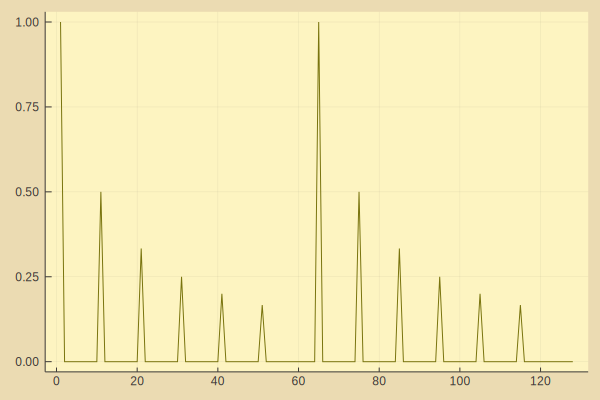

In [73]:
# Here we are trying to create N number of taps that space themselves evenly
# across the pattern length. This is the maximum possible amount of spread for
# the taps.

function generate_taps(pattern_length, num_taps)
    [(trunc(Int, (pattern_length / (num_taps + 1))) * i, 1 / (i + 1)) for i=1:num_taps]
end

pattern_length = 64

taps = generate_taps(pattern_length, 5);

output = multitap_delay(impulse, taps, pattern_length, 0.5);

plot(output, legend=false)